# Library

In [52]:
import rasterio
from matplotlib import pyplot as plt
import pickle
import numpy as np
from tsmoothie.smoother import LowessSmoother
from mpl_toolkits.mplot3d import axes3d
from datetime import datetime
import skfda
from skfda.representation.interpolation import SplineInterpolation
from sklearn.preprocessing import normalize

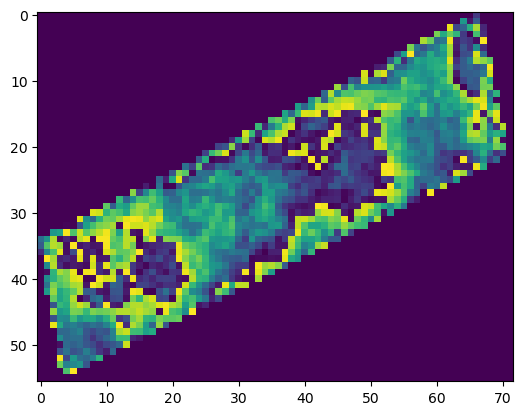

In [53]:
campo3 = rasterio.open(r'./readImage/campo3.tiff')
plt.imshow(campo3.read(1))

# load fields and yields

(57, 12, 56, 72)


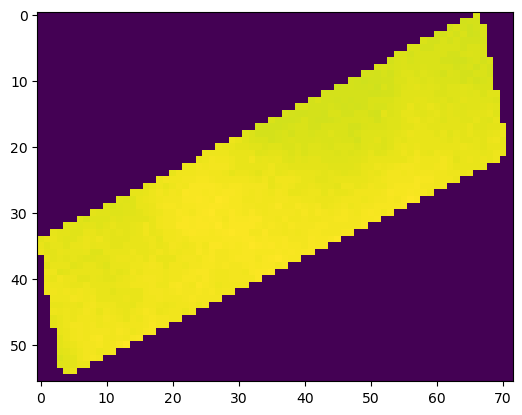

In [54]:
with open('./pickles/campo3_bande.pickle', 'rb') as handle:
    campo3 = pickle.load(handle)
print(campo3.shape)
plt.imshow(campo3[4][2])

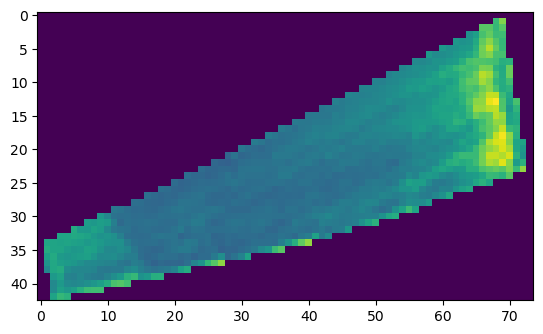

In [55]:
with open('./pickles/campo4_bande.pickle', 'rb') as handle:
    campo4 = pickle.load(handle)
plt.imshow(campo4[30][2])

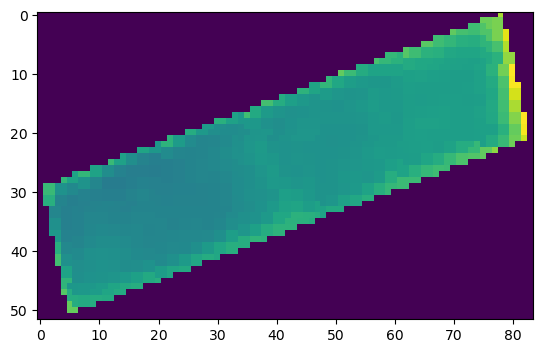

In [56]:
with open('./pickles/campo6_bande.pickle', 'rb') as handle:
    campo6 = pickle.load(handle)
plt.imshow(campo6[40][10])

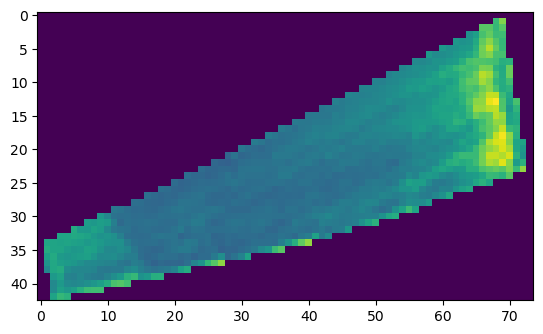

In [57]:
with open('./pickles/campo4_bande.pickle', 'rb') as handle:
    campo4 = pickle.load(handle)
plt.imshow(campo4[30][2])

In [58]:
resa3 = rasterio.open(r'OUTPUT.tif')
resa3 = resa3.read(1)

(1579,)


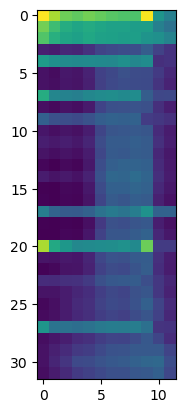

In [59]:
newImage3 = []
newResa3 = []
for x in range(0, campo3.shape[2]):
    for y in range(0,campo3.shape[3]):
        if(np.sum(campo3[:,:,x,y] != 0)):
            newImage3.append(campo3[18:50,:,x,y]/12000) # Reccomended value for normalization
            newResa3.append(resa3[x,y])
newResa3 = np.array(newResa3)
print(newResa3.shape)
plt.imshow(newImage3[10])

# Save the normalized yield
with open('./pickles/newResa3.pickle', 'wb') as handle:
    pickle.dump(newResa3, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Smoothing the bands for all pixels

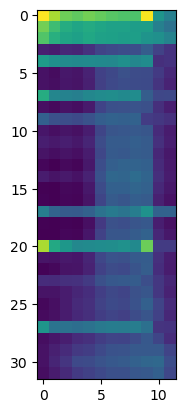

In [60]:
imageSmooth = newImage3

# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.01, iterations=1)

for x in range(len(newImage3)):
    for banda in range(0,campo3.shape[1]):
        imageSmooth[x][:,banda] = smoother.smooth(newImage3[x][:,banda]).smooth_data[0]

plt.imshow(imageSmooth[10])


(1579, 32, 12)


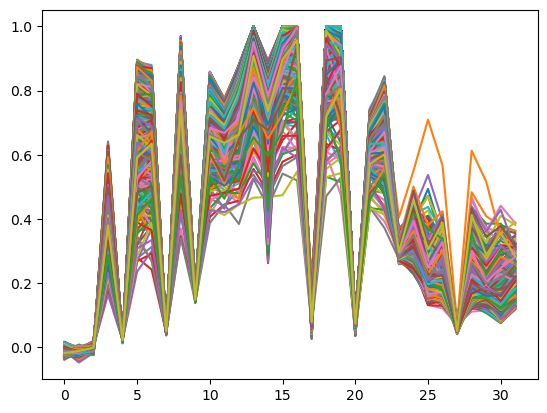

In [61]:
print(np.array(imageSmooth).shape)
for a in range(0,np.array(imageSmooth).shape[0]):
    plt.plot((imageSmooth[a][:,7]-imageSmooth[a][:,3])/(imageSmooth[a][:,7]+imageSmooth[a][:,3]))

# Interpolation

In [62]:
date = ['2016-11-05', '2016-11-12', '2016-11-15', '2016-11-22', '2016-11-25', '2016-12-02', '2016-12-05', '2016-12-12', '2016-12-15', '2016-12-22', '2016-12-25', '2017-01-01', '2017-01-04', '2017-01-14', '2017-01-24', '2017-01-31', '2017-02-03', '2017-02-10', '2017-02-13', '2017-02-20', '2017-02-23', '2017-03-02', '2017-03-05', '2017-03-12', '2017-03-15', '2017-03-22', '2017-03-25', '2017-04-01', '2017-04-04', '2017-04-11', '2017-04-14', '2017-04-21', '2017-04-24', '2017-05-01', '2017-05-04', '2017-05-11', '2017-05-14', '2017-05-21', '2017-05-24', '2017-05-31', '2017-06-03', '2017-06-10', '2017-06-13', '2017-06-20', '2017-06-23', '2017-06-30', '2017-07-03', '2017-07-08', '2017-07-10', '2017-07-13', '2017-07-15', '2017-07-18', '2017-07-20', '2017-07-23', '2017-07-25', '2017-07-28', '2017-07-30']
days = []
zeroDay = datetime.strptime("2017-01-01","%Y-%m-%d")
date_cut = date[18:50]
for a in date_cut:
    days.append((datetime.strptime(a,"%Y-%m-%d")-zeroDay).days)

print(days)

grid_points = days  # Grid points of the curves

inter = skfda.FDataGrid(
    data_matrix=np.transpose(imageSmooth), #imageSmooth[0]
    grid_points=grid_points,
)
 

[43, 50, 53, 60, 63, 70, 73, 80, 83, 90, 93, 100, 103, 110, 113, 120, 123, 130, 133, 140, 143, 150, 153, 160, 163, 170, 173, 180, 183, 188, 190, 193]


In [63]:
inter.interpolation = SplineInterpolation(
    interpolation_order= 3
)

In [64]:
step = 5
test = inter.interpolation._evaluate(inter,range(43,193,step))
print(test[:,:,:].shape)


(12, 150, 1579)


In [65]:
inter = []
allPixel = []
for a in range(0,np.array(imageSmooth).shape[0]):
    inter.append(skfda.FDataGrid(
        data_matrix = np.transpose(imageSmooth[a]),
        grid_points = grid_points,
        interpolation = SplineInterpolation(interpolation_order= 3)
    ))
    allPixel.append(inter[-1].interpolation._evaluate(inter[-1],range(43,193,step))[:,:,0])

(1579, 12, 150)


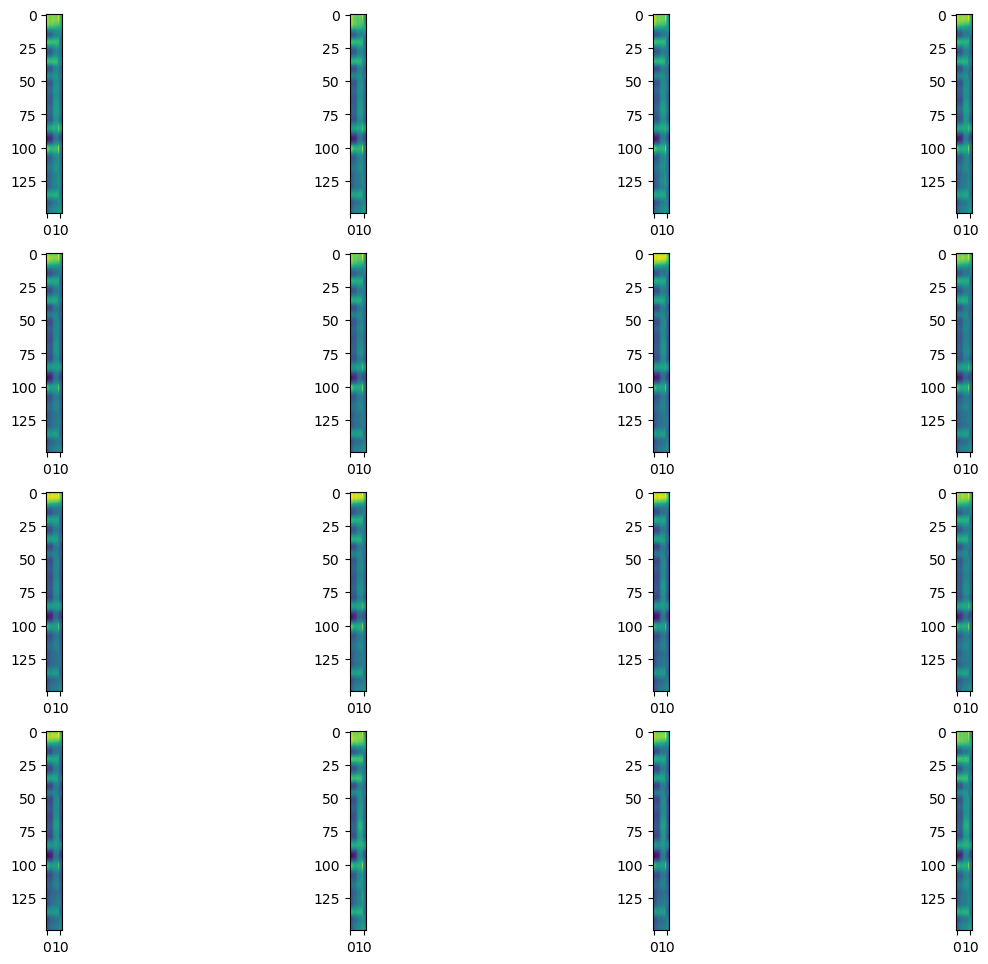

In [66]:
allPixel = np.array(allPixel)
print(allPixel.shape)
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,17):
    img = np.transpose(allPixel[(i*70),:,:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Save the processed band data

In [35]:
print(allPixel[10:20,7,15])

with open('./pickles/AllPixelBand3.pickle', 'wb') as handle:
    pickle.dump(allPixel, handle, protocol=pickle.HIGHEST_PROTOCOL)

[0.34217857 0.35847619 0.3742619  0.37434524 0.3640119  0.36269048
 0.35546429 0.35042857 0.35339286 0.34484524]


# Attempt to enhance small differences between pixels

In [38]:
Prüfung = allPixel
Prüfung = (Prüfung*100)-100
Prüfung = (Prüfung- np.min(Prüfung))/np.ptp(Prüfung)

(1579, 12, 30)


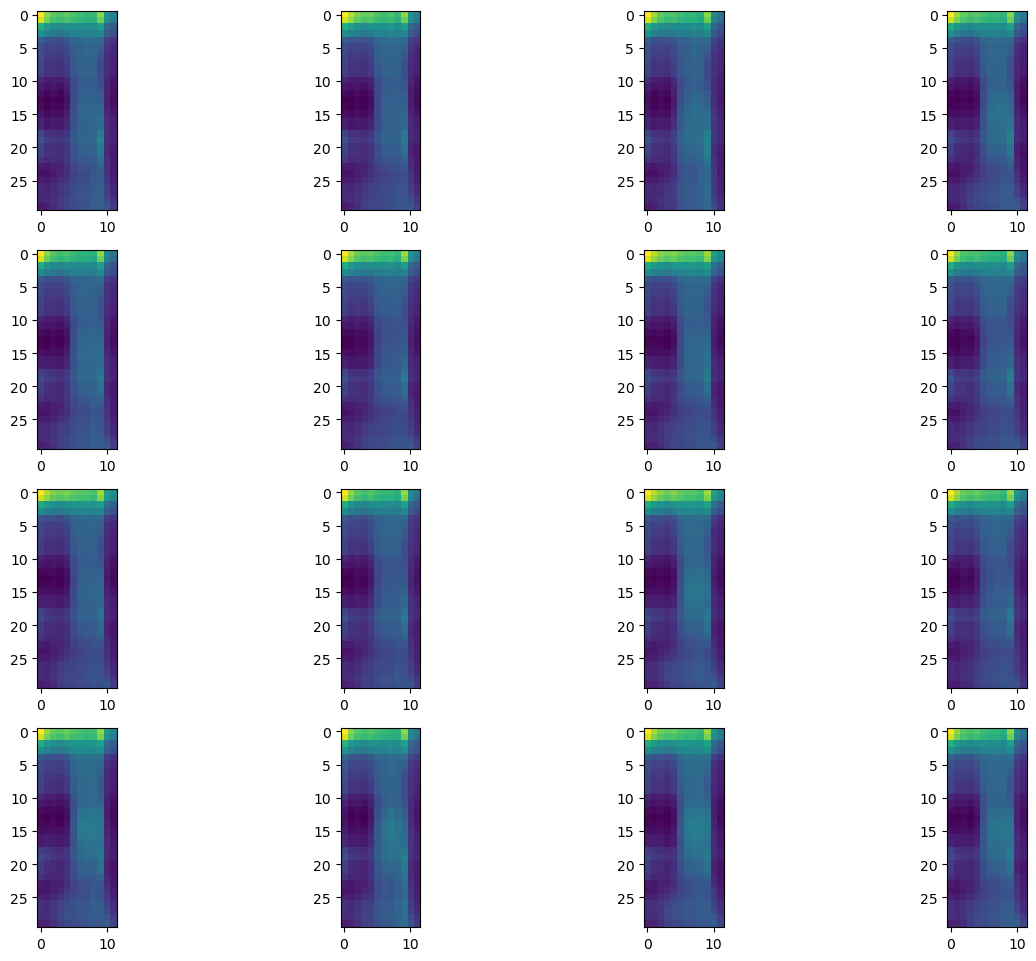

In [39]:
print(Prüfung.shape)
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,17):
    img = np.transpose(Prüfung[(i*70),:,:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [40]:
print(Prüfung[10:20,7,15])

[0.28994112 0.30712797 0.31768735 0.31706911 0.30515232 0.30230499
 0.30124705 0.29240774 0.29453101 0.28977867]
